There is one main quest and several side-quests after that. To get the full grade, you need attain 10 or more points in whichever way you want.

### Part 1: Memory-efficient training (5 pts)

![img](https://steamuserimages-a.akamaihd.net/ugc/280721626864094662/C48355EE16889197B8D000A198F970CD7E64CB7A/?imw=512&imh=342&ima=fit&impolicy=Letterbox&imcolor=%23000000&letterbox=true)

__Your quest__ is to fine-tune a GPT-2-Large by fitting it into 11GiB GPU memory (as in 1080Ti or 2080Ti). We deliberately limit GPU memory below and recommend you to check the peak memory usage via: [`torch.cuda.max_memory_allocated()`](https://pytorch.org/docs/stable/generated/torch.cuda.max_memory_allocated.html).



In [1]:
import torch
import transformers
from datasets import load_dataset
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import logging
import sys
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

device = torch.device('cuda', 3)

max_memory_gib = torch.cuda.get_device_properties(device).total_memory / 2 ** 30
torch.cuda.set_per_process_memory_fraction(min(1.0, 11 / max_memory_gib)) # todo: uncoment after debugging

print(f"Setting memory limit to {min(1.0, 11 / max_memory_gib) * 100:.2f}%")

Setting memory limit to 34.65%


In [2]:
transformers.__version__


'4.17.0'

GPT-2 is a [popular language model by OpenAI](https://openai.com/blog/better-language-models/). We're gonna use [huggingface transformers](https://huggingface.co/docs/transformers/index) as a shortcut to access this model. Here's how it works:

In [ ]:
model_name = 'gpt2-large'
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
model = transformers.GPT2LMHeadModel.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
# here's how the model works: tokenizer converts raw data to pytorch tensors

batch = tokenizer(["A cat sat", "import numpy"], return_tensors='pt')
print("Batch:", repr(batch)[:70].replace('\n', ' '), ' ...')

In [ ]:
# model turns those tensors into logits (pre-softmax activations)
pred = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])

print("Logits shape:", pred.logits.shape, " -- [batch size, sequence_length, vocab size]")
print(f"Parameters: {sum(param.numel() for param in model.parameters())/1e6:0.2f} million")

In [ ]:
generated_ids = model.generate(**batch, max_length=16)
print("Sample A:", tokenizer.decode(generated_ids[0]))
print("Sample B:", tokenizer.decode(generated_ids[1]))

tokenizer.pad_tokenHere's a sample data you can use for prototyping -- and demonstrating that your algorithm works.

In [18]:
dataset = load_dataset("wikitext", "wikitext-2-v1")['train']
test_batch = tokenizer(sorted(dataset['text'], key=len)[-64:], max_length=1024, padding=True, pad_to_multiple_of=256, return_tensors='pt')

# if you want actual training, consider this dataset: https://huggingface.co/datasets/transformersbook/codeparrot

Reusing dataset wikitext (/home/alekseyen/.cache/huggingface/datasets/wikitext/wikitext-2-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126)


  0%|          | 0/3 [00:00<?, ?it/s]

/home/alekseyen/miniconda3/envs/py39/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2287: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


In [8]:
test_batch

{'input_ids': tensor([[ 1629,  1279,  2954,  ..., 50256, 50256, 50256],
        [14207,   262, 15191,  ..., 50256, 50256, 50256],
        [  383,  5358,  1022,  ..., 50256, 50256, 50256],
        ...,
        [  383, 20281,   286,  ..., 50256, 50256, 50256],
        [ 1052, 36363,   705,  ..., 50256, 50256, 50256],
        [ 1629,   262,   976,  ..., 50256, 50256, 50256]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [9]:
# model(**test_batch)

We can see that **one batch has already cause OOM** in full precision model

### Victory conditions

- __(1/5 points)__ it trains in some shape or form, regardless of batch size and optimizer
- __(2/5 points)__ it trains with sequence length 1024, batch size 64, with any optimizer (e.g. SGD)
- __(3/5 points)__ same, but using the Adam optimizer, and the training loss is demonstrated to decrease on a fixed batch
- __(4/5 points)__ most of the computation (flops) should pe performed on GPU, the training performance is at least 0.5x as fast as simply running forward/backward on GPU (in terms of sequences per second)
- __(5/5 points)__ __master parameters should be kept in full float32 precision__.


__How do I do that?__ There's a bunch of things you could try: you can pick and choose which of them you employ. Below are some (but not all) options:
- __Gradient accumulation / micro-batching:__ you probably can't process 64 sequences at once -- but what if you accumulate them over several forward/batckward passes with a smaller batch size.
- __Gradient checkpointing:__ you can further reduce activation memory by not storing intermediate activations. You can learn how to usa built-in checkpoints [from their docs](https://huggingface.co/docs/transformers/main_classes/model) or build your own using [vanilla checkpointing](https://pytorch.org/docs/stable/checkpoint.html).
- __Mixed precision:__ you can use [pytorch AMP](https://pytorch.org/docs/stable/amp.html) to cast activations to 16-bit. If that is not enough, you can cast (some) parameters to 16-bit as well. Victory conditions require that the optimized parameters must stay 32-bit, but no one said you must keep GPU parameters that way.
- __Offloading:__ any tensor you don't need right now can be offloaded from GPU to RAM. This is especially true for optimizer statistics.
- __Quantization:__ if everything else fails, you could reduce memory usage further via 8-bit quantization, [e.g. for Adam](https://github.com/facebookresearch/bitsandbytes). However, please make sure the loss still goes down after you're done blaspheming.



__Off limits:__
- using more than 11GiB of GPU memory at any point is forbidden (check with [`torch.cuda.max_memory_allocated()`](https://pytorch.org/docs/stable/generated/torch.cuda.max_memory_allocated.html))
- using non-Adam optimizer (e.g. SGD) will only count for 2/5 points. __Adafactor is not Adam__. But FusedAdam or quantized Adam are both legit -- if you can show that the loss goes down;
- finetuning must update all model parameters on every batch; fine-tuning only a subset of parameters will not get a full grade;
- changing the model structure - your code must run the same computation as the original GPT-2-large up to a floating point precision. Removing layers can be useful in practice, but it's off limits for this task.
- deepspeed and fairscale. There's a separate ~~cauldron~~ assignment for that.

In [4]:
class WikiTextDataset(Dataset):  
    def __init__(self, tokenizer: 'transformers.models', max_length=1024, split='train'):
        # self.sentences = [tokenizer(row, max_length=max_length, padding=True, return_attention_mask=True, return_tensors='pt') 
        #                   for row in tqdm(dataset['text'])]
        self.dataset = load_dataset("wikitext", "wikitext-2-v1", split = split)
        self.tokenizer = tokenizer
        
        self.sentences_count = len(self.dataset)
        
    def __len__(self):
        return self.sentences_count

    def __getitem__(self, idx):
        text = self.dataset['text'][idx]
        tokenized = self.tokenizer(text, return_tensors='pt', max_length=1024, padding='max_length', truncation=True, return_attention_mask=True)

    
        return {'input_ids': tokenized['input_ids'].to(device),
                'attention_mask': tokenized['attention_mask'].to(device),
                'labels': tokenized['input_ids'].to(device),
                'use_cache': False
               }
    
wikitext_traindataset = WikiTextDataset(tokenizer)
wikitext_testdataset = WikiTextDataset(tokenizer, split='test')

print('Max Alloc:', round(torch.cuda.max_memory_allocated(0)/1024**3, 1), 'GB')

Reusing dataset wikitext (/home/alekseyen/.cache/huggingface/datasets/wikitext/wikitext-2-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126)
Reusing dataset wikitext (/home/alekseyen/.cache/huggingface/datasets/wikitext/wikitext-2-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126)


In [15]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = "0"
os.environ["WANDB_DISABLED"] = "true"
# os.environ["TOKENIZERS_PARALLELISM"] = 'false'
# os.environ["WORLD_SIZE"]="-1"
# os.environ["RANK"]="-1"

In [16]:
loss = 0
model = model.to(device)


In [17]:
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding

# data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True, max_length=1024, return_tensors='pt')

training_args = TrainingArguments(
    evaluation_strategy = "steps",
    gradient_checkpointing=True,
    gradient_accumulation_steps=1000,
    seed=42,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    fp16=True,
    num_train_epochs=2,
    output_dir='week04TrainerOutput',
    overwrite_output_dir=True,
    disable_tqdm=False,
    optim='adafactor',
    logging_dir = 'tensorboard_dir', # for tensorboard
    log_level = 'debug',
    logging_steps = 10,
    eval_steps = 10
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=wikitext_traindataset,   
    eval_dataset=wikitext_testdataset,
)

Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using amp half precision backend


In [18]:
trainer.args._n_gpu = 1

In [20]:
results = trainer.train()

***** Running training *****
  Num examples = 36718
  Num Epochs = 2
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1000
  Gradient Accumulation steps = 1000
  Total optimization steps = 72


Step,Training Loss,Validation Loss
10,1.362000,0.184732
20,0.188400,0.175394
30,0.186000,0.171439
40,0.193500,0.169672
50,0.179900,0.169216
60,0.176700,0.168550
70,0.175100,0.168295


***** Running Evaluation *****
  Num examples = 4358
  Batch size = 1
***** Running Evaluation *****
  Num examples = 4358
  Batch size = 1
***** Running Evaluation *****
  Num examples = 4358
  Batch size = 1
***** Running Evaluation *****
  Num examples = 4358
  Batch size = 1
***** Running Evaluation *****
  Num examples = 4358
  Batch size = 1
***** Running Evaluation *****
  Num examples = 4358
  Batch size = 1
***** Running Evaluation *****
  Num examples = 4358
  Batch size = 1


Training completed. Do not forget to share your model on huggingface.co/models =)




In [27]:
print(results)

print('Max Alloc:', round(torch.cuda.max_memory_allocated(0)/1024**3, 1), 'GB')

Max Alloc: 7.9 GB


After tunning Trainer paramters we squeeze our model and optimzer in 11 GB GPU 

But only 1 batch is 

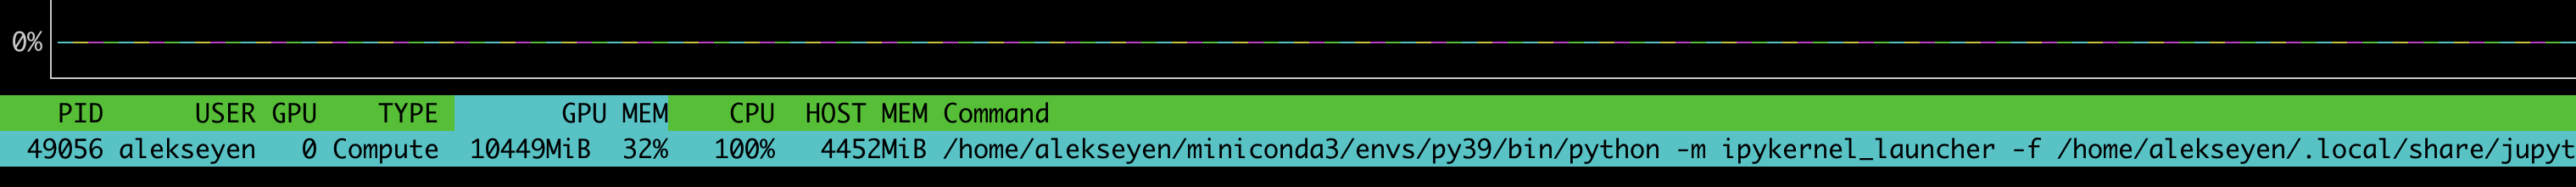

We also can see that training so slow, but now we don't care

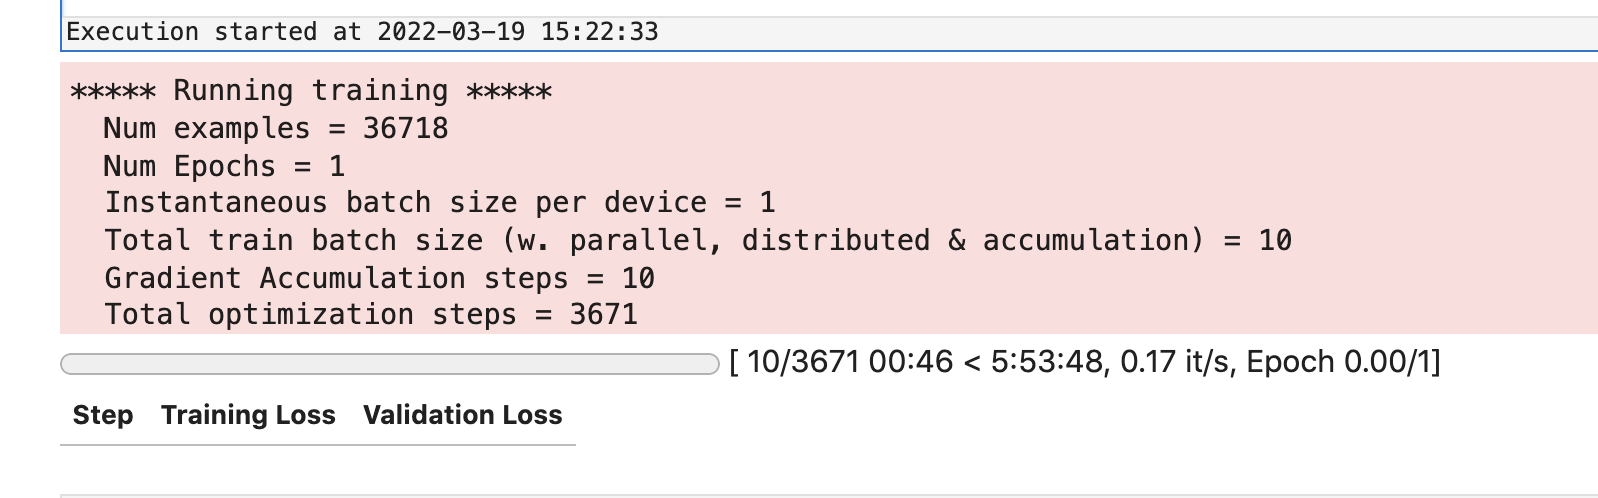

## Trainer result

train stage:
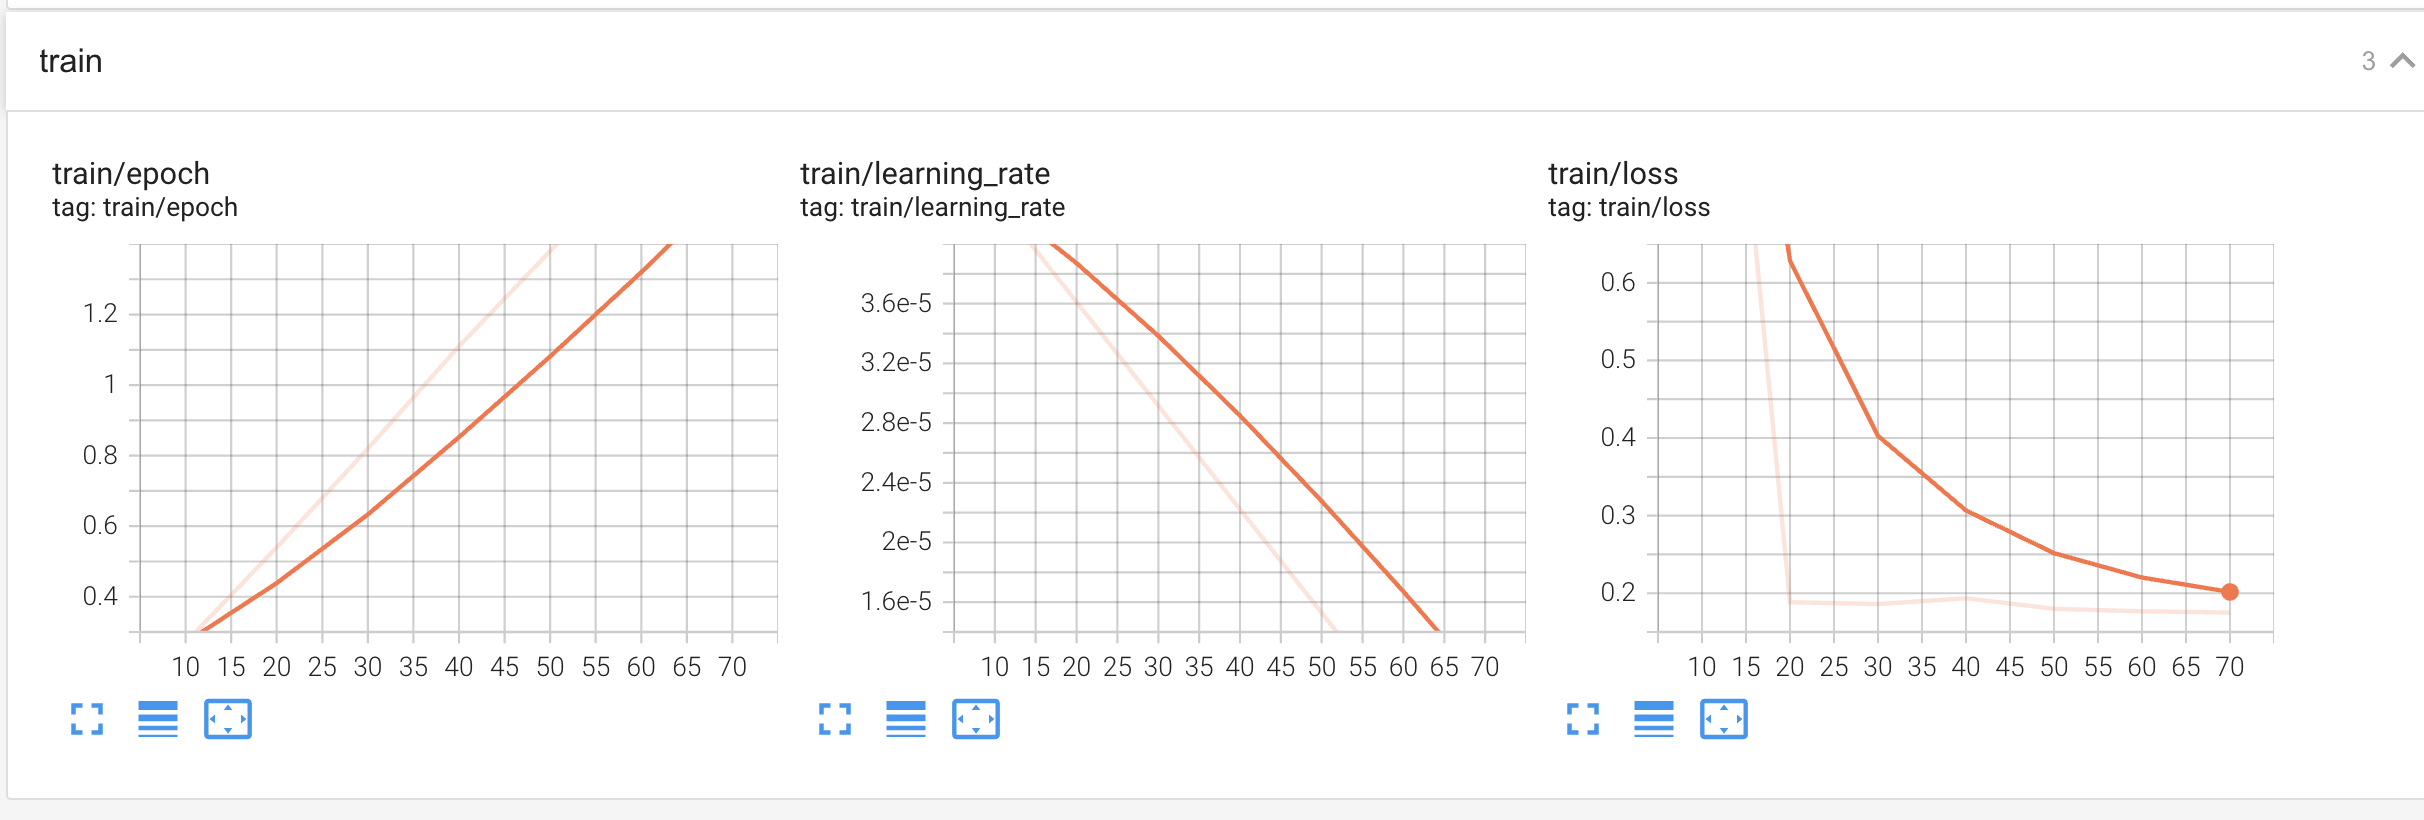

eval stage:
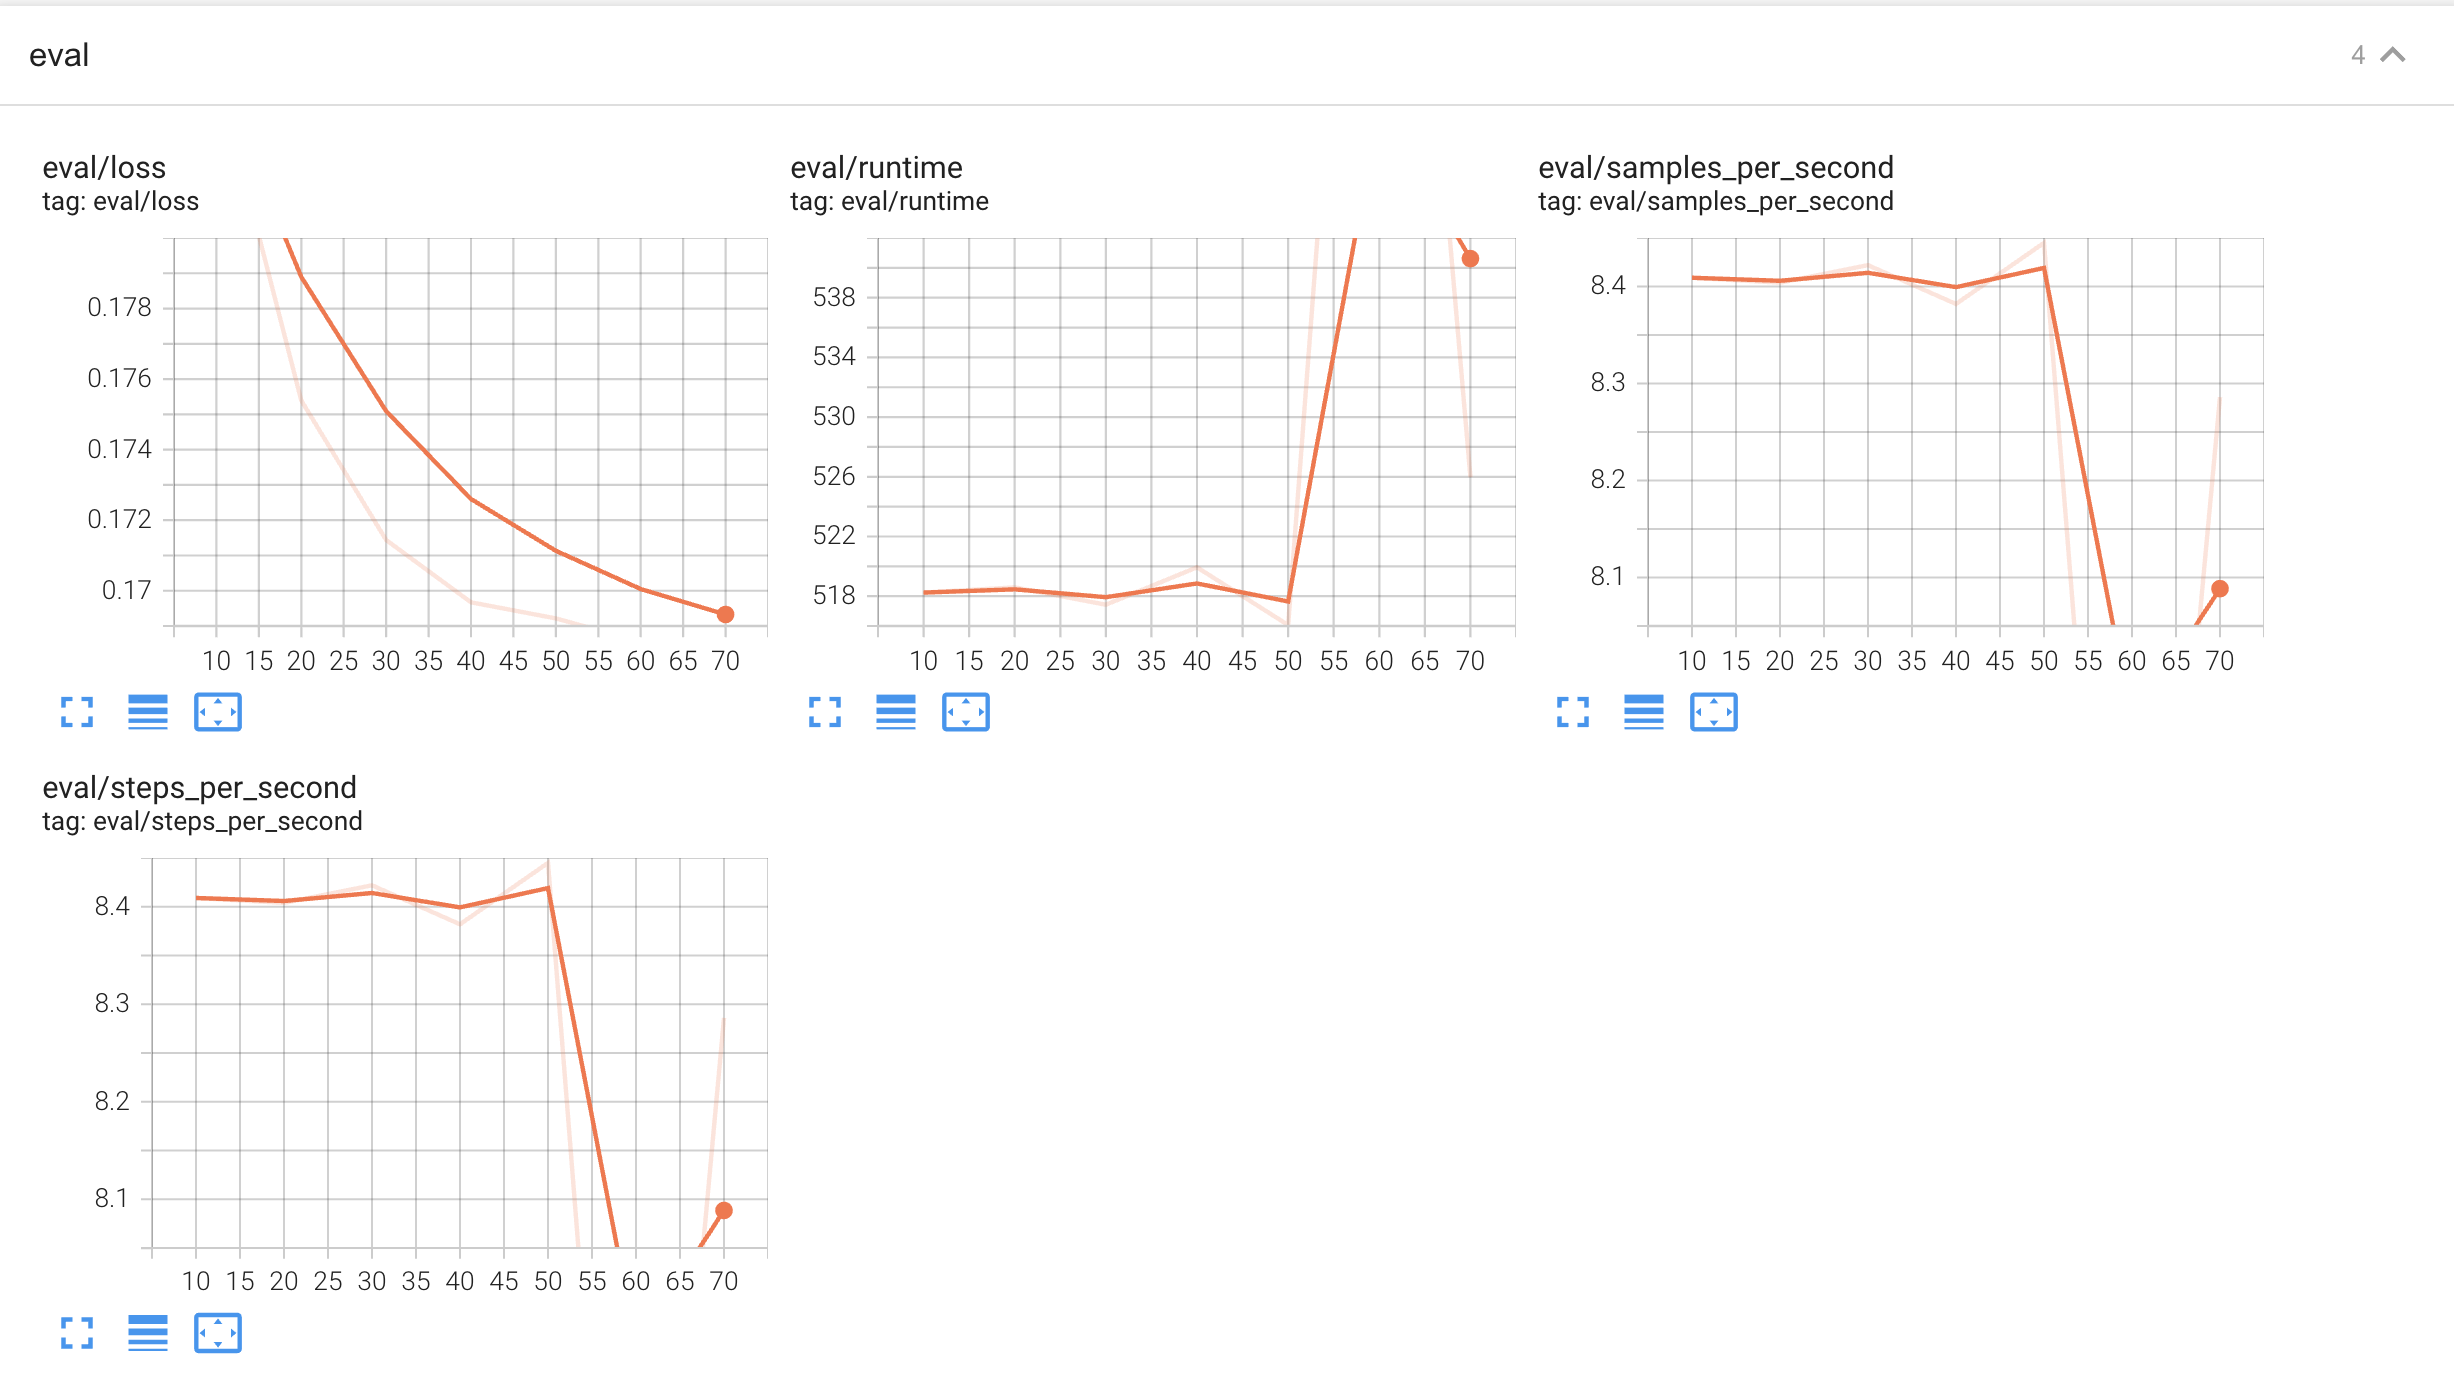

# My learning version

In [3]:
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from transformers import get_linear_schedule_with_warmup
from matplotlib import pyplot as plt
import numpy as np

class WikiTextDataset(Dataset):  
    def __init__(self, tokenizer: 'transformers.models', max_length=1024, split='train'):
        self.dataset = load_dataset("wikitext", "wikitext-2-v1", split = split, keep_in_memory=False)
        self.tokenizer = tokenizer
        
        self.sentences_count = len(self.dataset)
        
    def __len__(self):
        return self.sentences_count

    def __getitem__(self, idx):
        text = self.dataset['text'][idx]
        tokenized = self.tokenizer(text, return_tensors='pt', max_length=1024, padding='max_length', truncation=True, return_attention_mask=True)
    
        return {'input_ids': tokenized['input_ids'].to(device),
                'use_cache': False
               }
    
    
model_name = 'gpt2-large'
# model = transformers.GPT2LMHeadModel.from_pretrained(model_name).to(device).half()
model = transformers.GPT2LMHeadModel.from_pretrained(model_name).to(device).to(torch.bfloat16)

model.gradient_checkpointing_enable()
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
    
##########

wikitext_traindataset = WikiTextDataset(tokenizer)
wikitext_testdataset = WikiTextDataset(tokenizer, split='test')

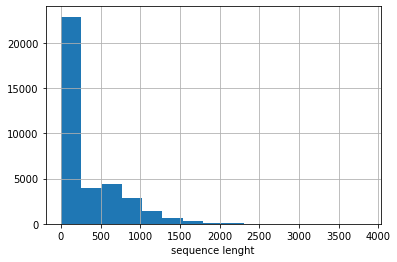

In [4]:
sentences_length = list(map(len, wikitext_traindataset.dataset['text']))
plt.hist(sentences_length, bins=15)
plt.ylabel('')
plt.grid()
plt.xlabel('sequence lenght');

In [5]:
(np.asarray(sentences_length) > 1024).sum(), len(wikitext_traindataset.dataset)

(2521, 36718)

In [6]:
36718/64

573.71875

Okey, accroding to task condition, we must fit 574 batch to train 1 epoch (that has batch_size=64).

But problems here, that 2521 more than 573..

It's means we can't use only gradient accumaltion to solve problem

In [ ]:
2521/574

4.39198606271777

So, we must find a way how to train this GPT with at least 5 full batch

### Approachs to do offloading

- Create *N* optimizerers for each parameters group and alternately move them to GPU
- Create one optimizer on CPU and copy all gradient to it, do step, copy results to GPU

Let's start with second, because it is look easier

In [4]:
def optimizer_to(optim, device):
    # found this code on Torch forumes
    for param in optim.state.values():
        if isinstance(param, torch.Tensor):
            param.data = param.data.to(device)
            if param._grad is not None:
                param._grad.data = param._grad.data.to(device)
        elif isinstance(param, dict):
            for subparam in param.values():
                if isinstance(subparam, torch.Tensor):
                    subparam.data = subparam.data.to(device)
                    if subparam._grad is not None:
                        subparam._grad.data = subparam._grad.data.to(device)

train_dataloader = DataLoader(wikitext_traindataset, batch_size=5, shuffle=True)
optimizer = torch.optim.Adam(model.parameters()) 
optimizer_to(optimizer,'cpu')
# [param.clone().to('cpu') for param in model.parameters()] 
# torch.clone(model.parameters())

model = model.train()

In [6]:
for idx, entry in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
    entry = entry['input_ids']
    optimizer.zero_grad()

    outputs = model(entry, labels=entry, use_cache=False)

    loss = outputs[0] # [1] is for logits
    
    loss.to('cpu').backward()

    optimizer.step()

    if idx % 10 == 0:
        print(f'{idx} \t {loss}')

  0%|          | 0/7344 [00:00<?, ?it/s]

0 	 8.875
10 	 0.51953125
20 	 1.0
30 	 0.06396484375
40 	 0.89453125
50 	 0.490234375
60 	 0.63671875
70 	 0.57421875
80 	 0.412109375
90 	 0.326171875
100 	 0.33203125
110 	 1.4140625
120 	 1.1875
130 	 0.578125
140 	 0.1279296875
150 	 0.0927734375
160 	 0.59765625
170 	 1.2890625
180 	 0.20703125
190 	 0.0277099609375
200 	 0.578125
210 	 0.310546875
220 	 0.57421875
230 	 0.32421875
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

Traceback (most recent call last):
  File "/home/alekseyen/miniconda3/envs/py39/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/tmp/ipykernel_48405/421389696.py", line 9, in <module>
    loss.to('cpu').backward()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/alekseyen/miniconda3/envs/py39/lib/python3.9/sit

TypeError: object of type 'NoneType' has no len()

In this scenario learning epoch will take more than 8:38:27 hours with 5 batchsize, i think it's good enough

### Another offloading approach – MultiOptimizer

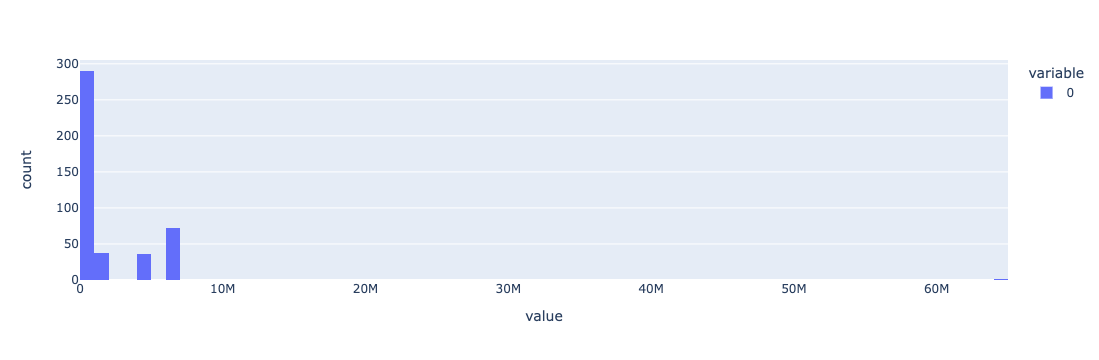

In [52]:
import plotly.express as px

px.histogram([parameter.numel() for idx, parameter in enumerate(model.parameters())])

So, for the last model layer (with ~65M parametrs, ofcourse it's linear layer)

In [153]:
import typing as tp

class MultipleAdamsOptimizer:
    def __init__(self, parameters: tp.Iterator[torch.nn.parameter.Parameter], group_number = 2, lr=2e-5):
        self.group_number = group_number
        self.parameters_list = list(parameters) # maybe shoud avoid, we seriously don't need copy them. if it happens ;) 
        self.number_of_parameters_in_each_group = self._count_number_parameters_each_group() 
        print(f'All: {self._count_all_parameters_values()}, per ours group: {self.number_of_parameters_in_each_group}')
        
        self.optimizers = []
        current_params_number, start = 0, 0
        
        for i in range(len(self.parameters_list)):
            current_params_number += self.parameters_list[i].numel()
            if current_params_number >= self.number_of_parameters_in_each_group:
                self.optimizers.append(torch.optim.Adam(self.parameters_list[start: i+1], lr=lr))
                start = i + 1
                current_params_number = 0
            elif i == len(self.parameters_list) - 1: # last bloks
                self.optimizers.append(torch.optim.Adam(self.parameters_list[start:], lr=lr))
        
        # checking if sum parameters sizes via groups is equal as source model number
        assert self._find_number_all_parameters_via_groups() == self._count_all_parameters_values()
            
    def _count_all_parameters_values(self):
        return sum(map(lambda x: x.numel(), self.parameters_list))
    
    def _count_number_parameters_each_group(self):
        return round(self._count_all_parameters_values() / self.group_number)
    
    def _find_number_all_parameters_via_groups(self):
        ans = 0
        for optimizer in self.optimizers:
            ans += sum(i.numel() for i in optimizer.param_groups[0]['params'])
        return ans
    
    def zero_grad(self):
        for op in self.optimizers:
            op.zero_grad()

    def step(self):
        for op in self.optimizers:
            op.step()

# optimizer = MultipleAdamsOptimizer(model.parameters())

TBA

Previous appoach looking pretty well

### Accumulating & final code wiht 64 batchsize

First of all, we should change `WikiTextDataset`, don't add paddings

In [22]:
def train(
    dataset, 
    model,
    batch_size=4,
    epochs=3, 
    lr=2e-5,
    max_seq_len=1024, 
    warmup_steps=200, 
    output_prefix="model_plus_metrics",
    save_model_on_epoch=False,
    is_tensorboard_needed=False,
):
    writer = SummaryWriter(log_dir=f'{output_prefix}/{datetime.now().strftime("%H:%M:%S")}')
    model = model.to(device)
    model.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr) 
    optimizer_to(optimizer, 'cpu')
    
    accum_iter = round(batch_size / 4)
    
    train_dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
    

    for epoch in range(epochs):
        
        input_tensor = None
        loss=0
        
        print(f"Accum iter is {accum_iter}")
        
        for batch_idx, entry in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
            input_tensor = entry['input_ids']

            outputs = model(input_tensor, labels=input_tensor, use_cache = False)

            loss = outputs[0] / accum_iter
            loss.to('cpu').backward()
                
                
            # weight updates
            if ((batch_idx + 1) % accum_iter == 0) or (batch_idx + 1 == len(train_dataloader)):
                optimizer.step()
                model.zero_grad()
                optimizer.zero_grad()
                
            
            if batch_idx % 50 == 0:
                print(f"BatchIdx: {batch_idx} \t loss: {loss}")
                if is_tensorboard_needed:
                    writer.add_scalar(f'{epoch}/train_loss', scalar_value=loss, global_step = idx)
            
        if save_model_on_epoch:
            torch.save(
                model.state_dict(),
                os.path.join(f"{output_prefix}/{epoch}.pt"),
            )
            
    return model

In [23]:
train(wikitext_traindataset, model, batch_size=64)

Accum iter is 16


  0%|          | 0/9180 [00:00<?, ?it/s]

BatchIdx: 0 	 loss: 0.06298828125
BatchIdx: 50 	 loss: 0.0220947265625
BatchIdx: 100 	 loss: 0.056640625
BatchIdx: 150 	 loss: 0.00811767578125
BatchIdx: 200 	 loss: 0.042236328125
BatchIdx: 250 	 loss: 0.0235595703125
BatchIdx: 300 	 loss: 0.00390625
BatchIdx: 350 	 loss: 0.0026702880859375
BatchIdx: 400 	 loss: 0.036865234375
BatchIdx: 450 	 loss: 0.02197265625
BatchIdx: 500 	 loss: 0.0089111328125
BatchIdx: 550 	 loss: 0.0174560546875
BatchIdx: 600 	 loss: 0.0576171875
BatchIdx: 650 	 loss: 0.04931640625
BatchIdx: 700 	 loss: 0.00372314453125
BatchIdx: 750 	 loss: 0.042236328125
BatchIdx: 800 	 loss: 0.036376953125
BatchIdx: 850 	 loss: 0.020751953125
BatchIdx: 900 	 loss: 0.02392578125
BatchIdx: 950 	 loss: 0.032958984375
BatchIdx: 1000 	 loss: 0.01708984375
BatchIdx: 1050 	 loss: 0.0126953125
BatchIdx: 1100 	 loss: 0.02734375
BatchIdx: 1150 	 loss: 0.044189453125
BatchIdx: 1200 	 loss: 0.0174560546875
BatchIdx: 1250 	 loss: 0.029052734375
BatchIdx: 1300 	 loss: 0.00909423828125
Ba

KeyboardInterrupt: 

### Results 
**I strongly think that this task is not about NLP, that's why i asked my model to learn current word instead of next. It looks stupid, and I know that, but now we don't care**
```
model(input_tensor, labels=input_tensor, use_cache = False) # <- totaly strange 
```

- Using usual Adam on CPU with full 32 precision
- Model parameters was on GPU in falf precision (4/5 points)
- ON GPU we store model in bf16 mode, but optimizer operate with 32 precision (Really thanks guy in tg chat that said to me replace `.half` on `.to(torch.bfloat16)` because my )
- Using accumulating techniques we learning our module with like `batch_size = 64` where each batch has len 1024
  
  In this part I also want to concatenate sentences, because there are a lot short one. But stoped in technique above
- For this learnign process we use 10599 GPU memory

Additional assignments: pick at least one for full grade, or more if you're into it.

### Pipeline parallelism (3+ points)

__TL;DR__ implement pipeline parallelism using [`torch.distributed`](https://pytorch.org/docs/stable/distributed.html) or [`torch.rpc`](https://pytorch.org/docs/stable/rpc.html), your choice.

![img](https://i.imgur.com/Va7GN6x.png)

Please start from [PyTorch CIFAR](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) starter kit. We will not judge if you choose something heavier, e.g. ImageNet -- but that is not necessary.
For this assignment, you will need to implement pipeline-parallel training similar to the one defined in [GPipe](https://arxiv.org/abs/1811.06965) (or lecture 4 notes). Feel free to use CPU or share one GPU for multiple processes. The main victory condition is that the model must show the same convergence rate as training on a single GPU -- which you will need to demosntrate.

- __(1/3 points)__ doesn't have to be parallel, works with at least 2 stages
- __(2/3 points)__ same parallelism as in GPipe, 4 or more stages, loss is shown to go down
- __(3/3 points)__ achieve the same covnergence curves on CIFAR (or the task of your choice) as training with a single process
- __(+1 bonus)__ demonstrate that your implementation can process a very large number of micro-batches (at least 1000 microbatches with 4 stages) without going OOM
- __(+1 bonus)__ implement [pipedream](https://arxiv.org/pdf/1806.03377.pdf) or [interleaved pipeline](https://openreview.net/pdf?id=cw-EmNq5zfD) (this may be hard!)

__Conditions:__ your implementation should use multiprocessing (i.e. not a single process sending data between devices). Existing pipelines (e.g. `torch.distributed.pipeline`) are off limits. If your code resembles one of existing pipelines too much, we will brutually interrogate you about the implementation details (as in "we'll make sure it's easier to build your own").



## Подходы к решению [доделать не успел, но успел придумать]
Обе реализации как предлогали ребята в Gpipe, только первая – для Sequential модели. Вторая переписать все слои, чтобы они мели правильно дожидаться и делать `backward` согласно рисунку

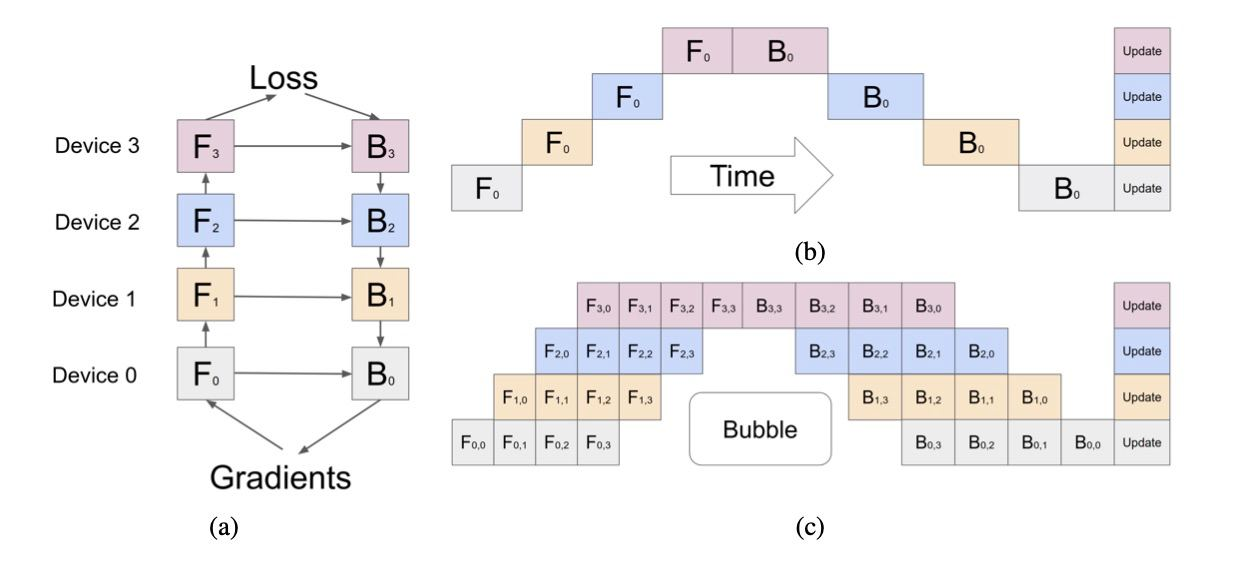

### 1. Для ~Sequential моделей
- Создаем объект сети на CPU, всей целиком
- Раскидываем `1/N` часть модулей на каждый процесс(то есть прям итерируемся по модулям)
- Инициализируем группу у соответствующего слоя прокидываем нужный модуль из списка модулей выше на нужную GPU
- Дальше делаем схему с общением как на рисунку

Начал писать реализацию в `part02_pipeline_parallelism.py`

### 2. Переписывание слоев
Аналогично с прошлой домашкой переписываем все слои(для цифара хватит Sequential, Conv и BatchNorm). Нужно и forward'е и в backward'е делать аккуратное ожидание


### Tensor Parallelism (3+ points)
_aka AlexNet-style parallelism_

__TL;DR__ implement intra-layer model parallelism and make sure it works.

Similarly to the pipeline task, we recommend that you start with the [PyTorch CIFAR](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) tutorial, but you can choose to use a more complex starter kit if you're feeling adventurous. If you don't have stable access to a multi-GPU setup, feel free to use CPU or share the same GPU across all processes.

The main objective is to implement AlexNet-style model parallelism, wherein each device computes a subset of "neurons" in each layer and then exchanges results with other units. We recommend doing this with [`torch.distributed`](https://pytorch.org/docs/stable/distributed.html) with either `all_reduce` or `all_gather`, depending on whether you split matrix rows or columns.

- __(1/3 points)__ a simple architecture, `Sequential(linear1, relu, linear2)`,
- __(2/3 points)__ a more complex architecture, add at least one batch- or layer normalization
- __(3/3 points)__ train a model like this and show learning curves,
- __(+1 bonus)__ parallelize either ResNet50 or some Transformer variant (__warning__, this is hard!),
- __(+1 bonus)__ implement mixed column + row parallelism, run 2 dense layers with a single communication round (see below).

For both options, please attach the learning curves of your model compared to regular single-process training. A decent explanation how this type of parallelism works can be found in Section 2.3 of [this paper](https://arxiv.org/pdf/2104.04473.pdf). Optimizations such as Figure 5 from that paper or this [weird trick](https://arxiv.org/abs/1404.5997) are welcome, but not required.


In [12]:
!torchrun --nproc_per_node 4 --master_port 10010 part03_tensor_parallelism.py

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
*****************************************
Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
*****************************************
2022-03-27 23:59:11,553 – INFO: 	 Added key: store_based_barrier_key:1 to store for rank: 2
2022-03-27 23:59:11,582 – INFO: 	 Added key: store_based_barrier_key:1 to store for rank: 1
2022-03-27 23:59:11,588 – INFO: 	 Added key: store_based_barrier_key:1 to store for rank: 0
2022-03-27 23:59:11,597 – INFO: 	 Added key: store_based_barrier_key:1 to store for rank: 3
2022-03-27 23:

Training graphs:


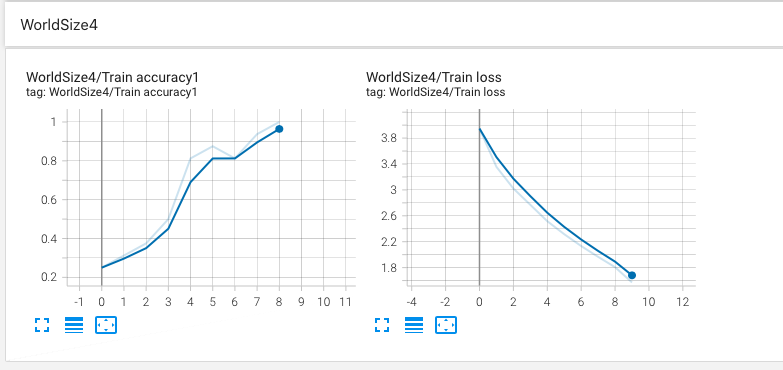


## Results

The main blowup idea that helps everythings (backward) works was:
```
x_gathered = [torch.zeros(x.size()).to(self.device) for _ in range(dist.get_world_size())]
dist.all_gather(x_gathered, x)
x_gathered[dist.get_rank()] = x  # <-----
```

It help gradient flows concatenate operation

### How to run
To run in CPU please uncoment 152 line and make `device='cpu'`

### Bigger and badder (3+ points)

__TL;DR__ repeat the first quest but for [GPT2-XL](https://huggingface.co/gpt2-xl) (~1.5B parameters) instead of GPT2-Large.

![img](https://i.imgflip.com/48jwa8.png)

- __(1/3 points)__ - do that with 16GiB GPU memory. If you can't get one through conventional means, try [free kaggle P100 quotas](https://www.kaggle.com/product-feedback/83643)
- __(2/3 points)__ - the training should be at least 0.5x as fast as running forward/backward on GPU
- __(3/3 points)__ - back to 11GiB memory and no more than 16GiB RAM
- __(+1 bonus)__ - actually fine-tune the model on something (e.g. code, [codeparrot](https://huggingface.co/datasets/transformersbook/codeparrot)) and compare its generated outputs

You will likely need to add more memory-saving tricks on top of what you used for GPT2-Large. It is okay to keep some parameters in fp16.
Alternatively, __Deepspeed and fairscale are no longer forbidden__, but beware that they are not a free win -- you will have to tune the configuration for your specific setup.

__Variant:__ if you somehow got your hands on a powerful GPU, we will also accept (A) [GPT-J-6B](https://huggingface.co/EleutherAI/gpt-j-6B) for 24-32GiB GPUs or multiple smaller ones (B) [T5-11B](https://huggingface.co/t5-11b) on any GPUs short of MI250X. Note that you still need to train the entire model: we will not accept solutions based on Denis' [8-bit + LoRA trick](https://huggingface.co/hivemind/gpt-j-6B-8bit).
